# 12-9. 프로젝트: End-to-End OCR

keras OCR의 Detector class를 이용해서 이미지 내의 문자 위치를 찾아내는 함수를 만들어보도록 하겠습니다.

이를 위해서 keras-ocr을 설치해주고 Detector를 만들어주세요.

### 목차

#### 1. 데이터 준비
#### 2. Recognition model 생성
#### 3. End-to-End OCR
#### 4. 루브릭 & 회고
#### 5. Reference

## 1. 데이터 준비

In [1]:
import os

path = os.path.join(os.getenv('HOME'), 'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


In [3]:
# LMDB(Lightning Memory-Mapped Database) 데이터셋 설치
!pip install lmdb

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## 2. Recognition model 생성
---
Text recognition 모델을 직접 만들어보도록 하겠습니다.

Recognition 모델은 2015년에 발표된 [논문](https://arxiv.org/pdf/1507.05717.pdf)에서 처음 소개된 CRNN 구조를 활용해서 만들어보도록 하겠습니다.

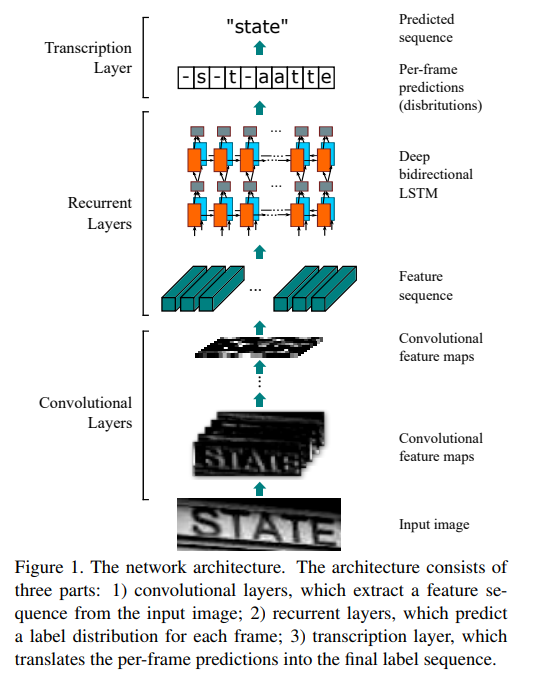

CRNN의 구조는 위 그림에서 아래부터 올라가는 순서로 보시면 됩니다.

1. 입력이미지를 Convolution Layer를 통해 Feature를 추출하여 추출된 Feature를 얻어냅니다.

2. Recurrent Layer는 추출된 Feature의 전체적인 Context를 파악하고 다양한 output의 크기에 대응이 가능합니다.

3. 끝으로 Transcription layer(Fully connected layer)는 step마다 어떤 character의 확률이 높은지 예측합니다.

아래의 표를 통해 정확한 구조를 확인해주세요.

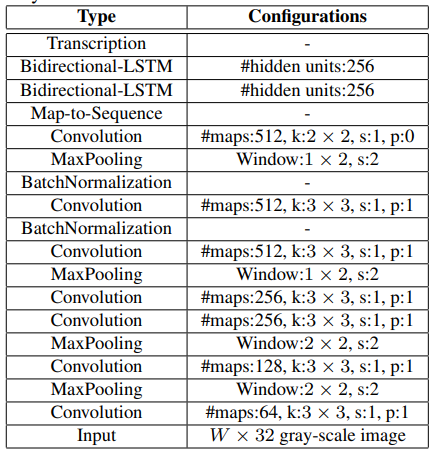

### 2-1. 필요한 라이브러리 import
---

In [2]:
# 몇 개의 class가 필요한지 확인하기 위해 다음 셀을 실행
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


- 총 36가지 (영어 대문자 26개, 숫자 10개)가 필요합니다.

- 문자가 없는 경우를 위해서 공백을 추가할 경우 class의 수는 37개가 됩니다.

In [4]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


### 2-2. Input Image
---

#### ㄱ. 데이터셋 안에 있는 이미지를 확인

아래의 코드를 실행해서 lmdb 를 통해 훈련데이터셋의 이미지를 4개만 열어서 실제 shape가 어떻게 생겼는지, 이미지나 라벨은 어떻게 달려 있는지 확인해보도록 하겠습니다.

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


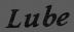

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


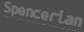

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


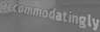

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


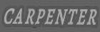

In [5]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

- 대부분의 이미지의 height는 31, 최대 32까지 되어 있고, width는 문자열의 길이에 따라 다양한 것으로 확인 할 수 있습니다.

#### ㄴ. lmdb를 활용하여 케라스 모델 학습용 MJSynth데이터셋 클래스를 구현

- `dataset_path` 는 읽어들일 데이터셋의 경로입니다.
- `label_converter` 는 아래에서 여러분이 문자를 미리 정의된 `index`로 변환해주는 `converter`로 직접 구현하도록 합니다.
- 이외에도 `batch_size`와 `입력이미지 크기` 그리고 `필터링을 위한 최대 글자 수`, 학습대상으로 한정하기 위한 `character`등을 입력으로 받도록 구현되어 있습니다.

In [6]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

print("슝~")

슝~


- 이미지 데이터를 img, label의 쌍으로 가져오는 부분을 `_get_img_label()` 메소드에 반영하였습니다.
- `model.fit()`에서 호출되는 `__getitem__()` 메소드에서 배치 단위만큼 `_get_img_label()` 를 통해 가져온 데이터셋을 리턴하게 될 것입니다.
- `_get_img_label()` 를 보면 다양한 사이즈의 이미지를 모두 height는 32로 맞추고, width는 최대 100까지로 맞추게끔 가공하고 있습니다.

### 2-3. Recognition model (3) Encode
---
이전 스텝에서 살펴본 바에 의하면, Label이 우리가 읽을 수 있는 평문 Text로 이루어져 있었습니다.

하지만, 이것은 모델을 학습하기 위해서 적절한 형태가 아닙니다.

따라서 각 Character를 class로 생각하고 이를 step에 따른 class index로 변환해서 encode를 해주어야 합니다.

- `LabelConverter` 클래스를 작성

    - `__init__()` 에서는 입력으로 받은 text를 `self.dict`에 각 character들이 어떤 index에 매핑되는지 저장합니다. 이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어집니다. 만약 `character='ABCD'`라면 `'A'`의 label은 1, `'B'`의 label은 2가 됩니다.
    
    - 공백(blank) 문자를 지정합니다. 여기서는 공백 문자를 뜻하기 위해 '-'를 활용하며, label은 0으로 지정합니다.
    
    - **decode()** 는 각 index를 다시 character로 변환한 후 이어주어 우리가 읽을 수 있는 text로 바꾸어줍니다.
    
    - 입력받은 text를 모델이 학습할 수 있는 label로 만드는 encode() 메소드를 구현하겠습니다.
    - 같은 글자가 연속적으로 이어지는 경우엔 이어지는 그 사이에 공백 문자의 label을 포함하겠습니다.

In [7]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label
    
print("슝~")

슝~


- 'HELLO'를 Encode한 후 Decode가 정상적으로 되는지 확인해보도록 하겠습니다.

In [8]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


- 'LEEHOJIN'를 Encode한 후 Decode가 정상적으로 되는지 확인

In [9]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('LEEHOJIN')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [12  5  0  5  8 15 10  9 14]
Decoded_text:  LE-EHOJIN


- 동일한 글자 'L', 'E' 가 연속이 될 때, 그 사이에 공백문자 '-'가 포함 된 것을 확인 할 수 있습니다.

### 2-4. Build CRNN model
---
입력과 출력을 준비했으니 모델을 만들어 보도록 하겠습니다.

#### ㄱ. `ctc_lambda_func` 구현
---
Keras에서 제공하는 `K.ctc_batch_cost()` 를 활용해서 loss를 계산하도록 `ctc_lambda_func`을 만들어보도록 하겠습니다.

In [10]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수 생성
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("슝~")

슝~


#### Keras의 `K.ctc_batch_cost()` 함수
---

CTC Loss 함수를 구현하기 위해 이 함수에 인자로 어떤 값을 넘겨야 하는지는 명확하게 파악해보도록 하겠습니다.

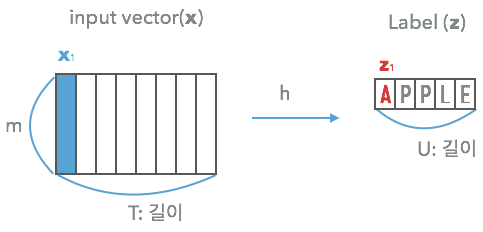

CTC Loss를 활용해야 하는 모델이 위 그림과 같은 상황을 다루기 위한 것입니다.

입력의 길이 T와 라벨의 길이 U의 단위가 일치하지 않을 때, 라벨은 `APPLE`이지만 모델이 출력한 결과는 `AAAPPPPLLLLEE` 처럼 나올 수 있습니다.

이런 상황이 이미지에서 텍스트 라벨을 추론해야 하는 Text recognition 태스크에 동일하게 적용됩니다.

(본 노드에는 아래의 설명을 적어 주었지만, 본인은 아래의 설명을 제대로 이해하지 못 하였습니다 ㅠ)
> 만약 모델이 AAAPPPPLLLLEE을 출력했다고 합시다. 이때 추론 결과는 APLE일지 APPLE일지 구분이 가능할까요? 이 경우에는 APLE로 결론을 내리게 될 것입니다.
>
> 그러므로 추론 결과가 APPLE이 되게 하려면 이미지의 라벨은 AP-PLE로 보정해 주어야 합니다. 그래서 모델이 AAAPP-PPLLLEE로 출력을 한다면 추론 결과는 APPLE이 되는 것입니다. 이런 이유로 이전 스텝에서 LabelConverter.encode() 메소드에 공백문자 처리로직을 포함했던 것입니다.

- [Tensorflow Tutorial - ctc_batch_cost
](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/backend/ctc_batch_cost)

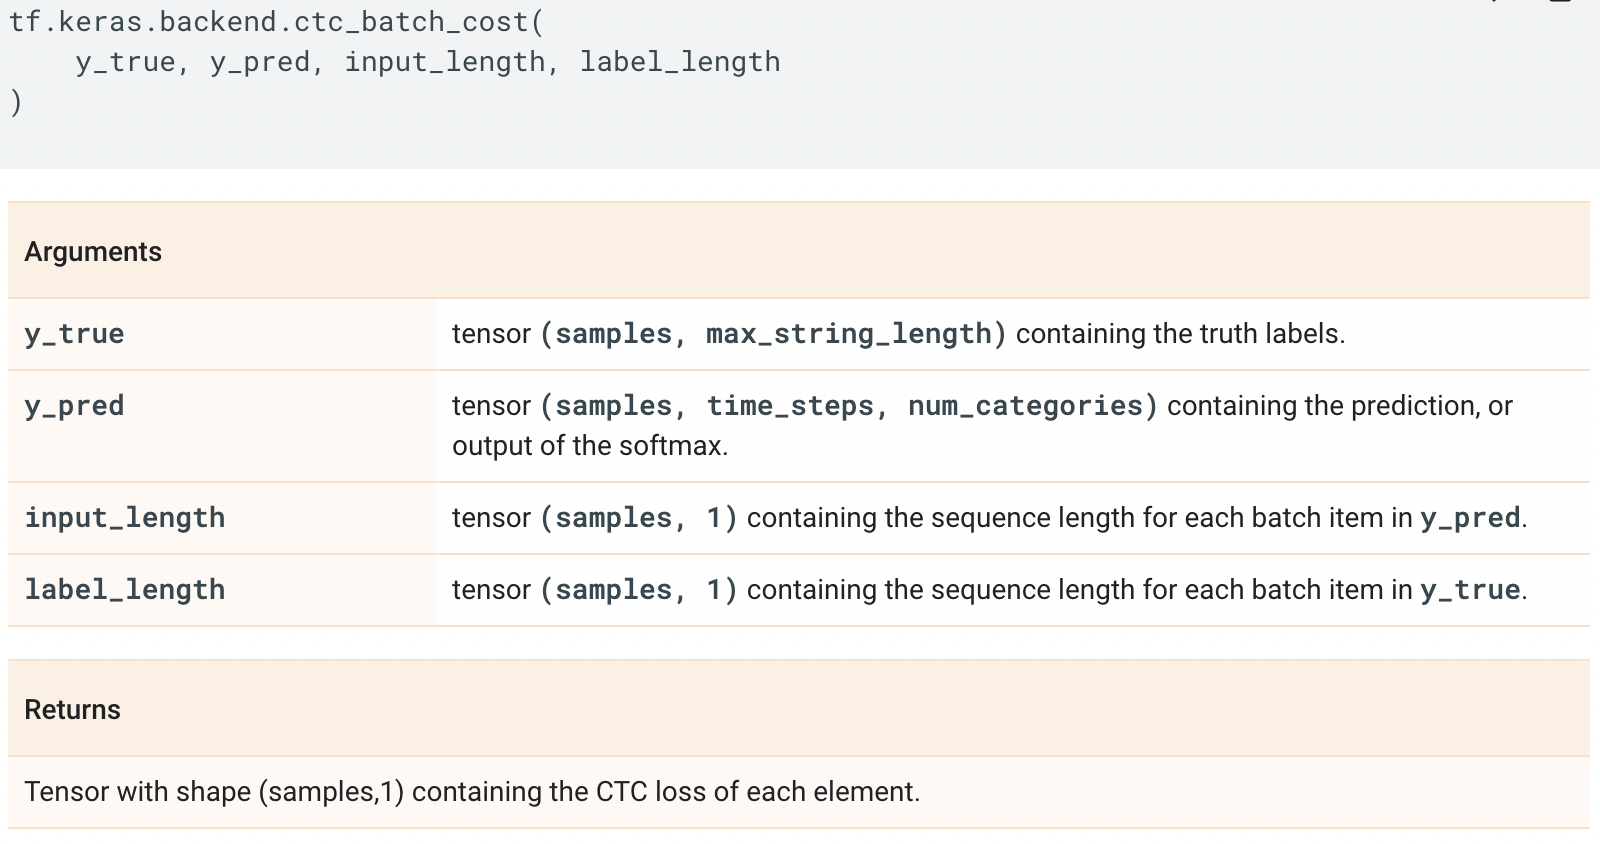

위 텐서플로우 튜토리얼에 따르면, K.ctc_batch_cost(y_true, y_pred, input_length, label_length)에는 4가지 인자가 존재합니다. 각각의 인자의 의미는 다음과 같습니다.

(여기서 samples는 배치사이즈를 의미합니다.)

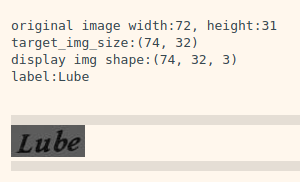

위의 케이스를 예를 들어 위의 인자들을 적용해보도록 하겠습니다.

- `y_true`: 실제 라벨 `LUBE`. 텍스트 라벨 그대로가 아니라, 각 글자를 One-hot 인코딩한 형태로서, max_string_length 값은 모델에서 22로 지정할 예정
- `y_pred`: RCNN `모델의 출력 결과`. 길이는 4가 아니라 RNN의 최종 출력 길이로서 24가 될 예정
- `input_length tensor`: 모델 입력 길이 T로서, 이 경우에는 텍스트의 width인 `74`
- `label_length tensor`: 라벨의 실제 정답 길이 U로서, 이 경우에는 `4`

#### ㄷ. `build_crnn_model()` 구현
---
`K.ctc_batch_cost()`를 활용하여, `image_input`을 입력으로, 마지막 Label을 'output'이라는 이름으로 출력하는 레이어를 갖도록 모델을 만들어보도록 하겠습니다.

In [11]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model
print("슝~")

슝~


In [12]:
# CRNN Model summary 출력
CRNN = build_crnn_model(input_shape=(100,32,3))
CRNN.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 32, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 32, 64)  1792        input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 50, 16, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 16, 128)  73856       max_pooling2d[0][0]              
______________________________________________________________________________________________

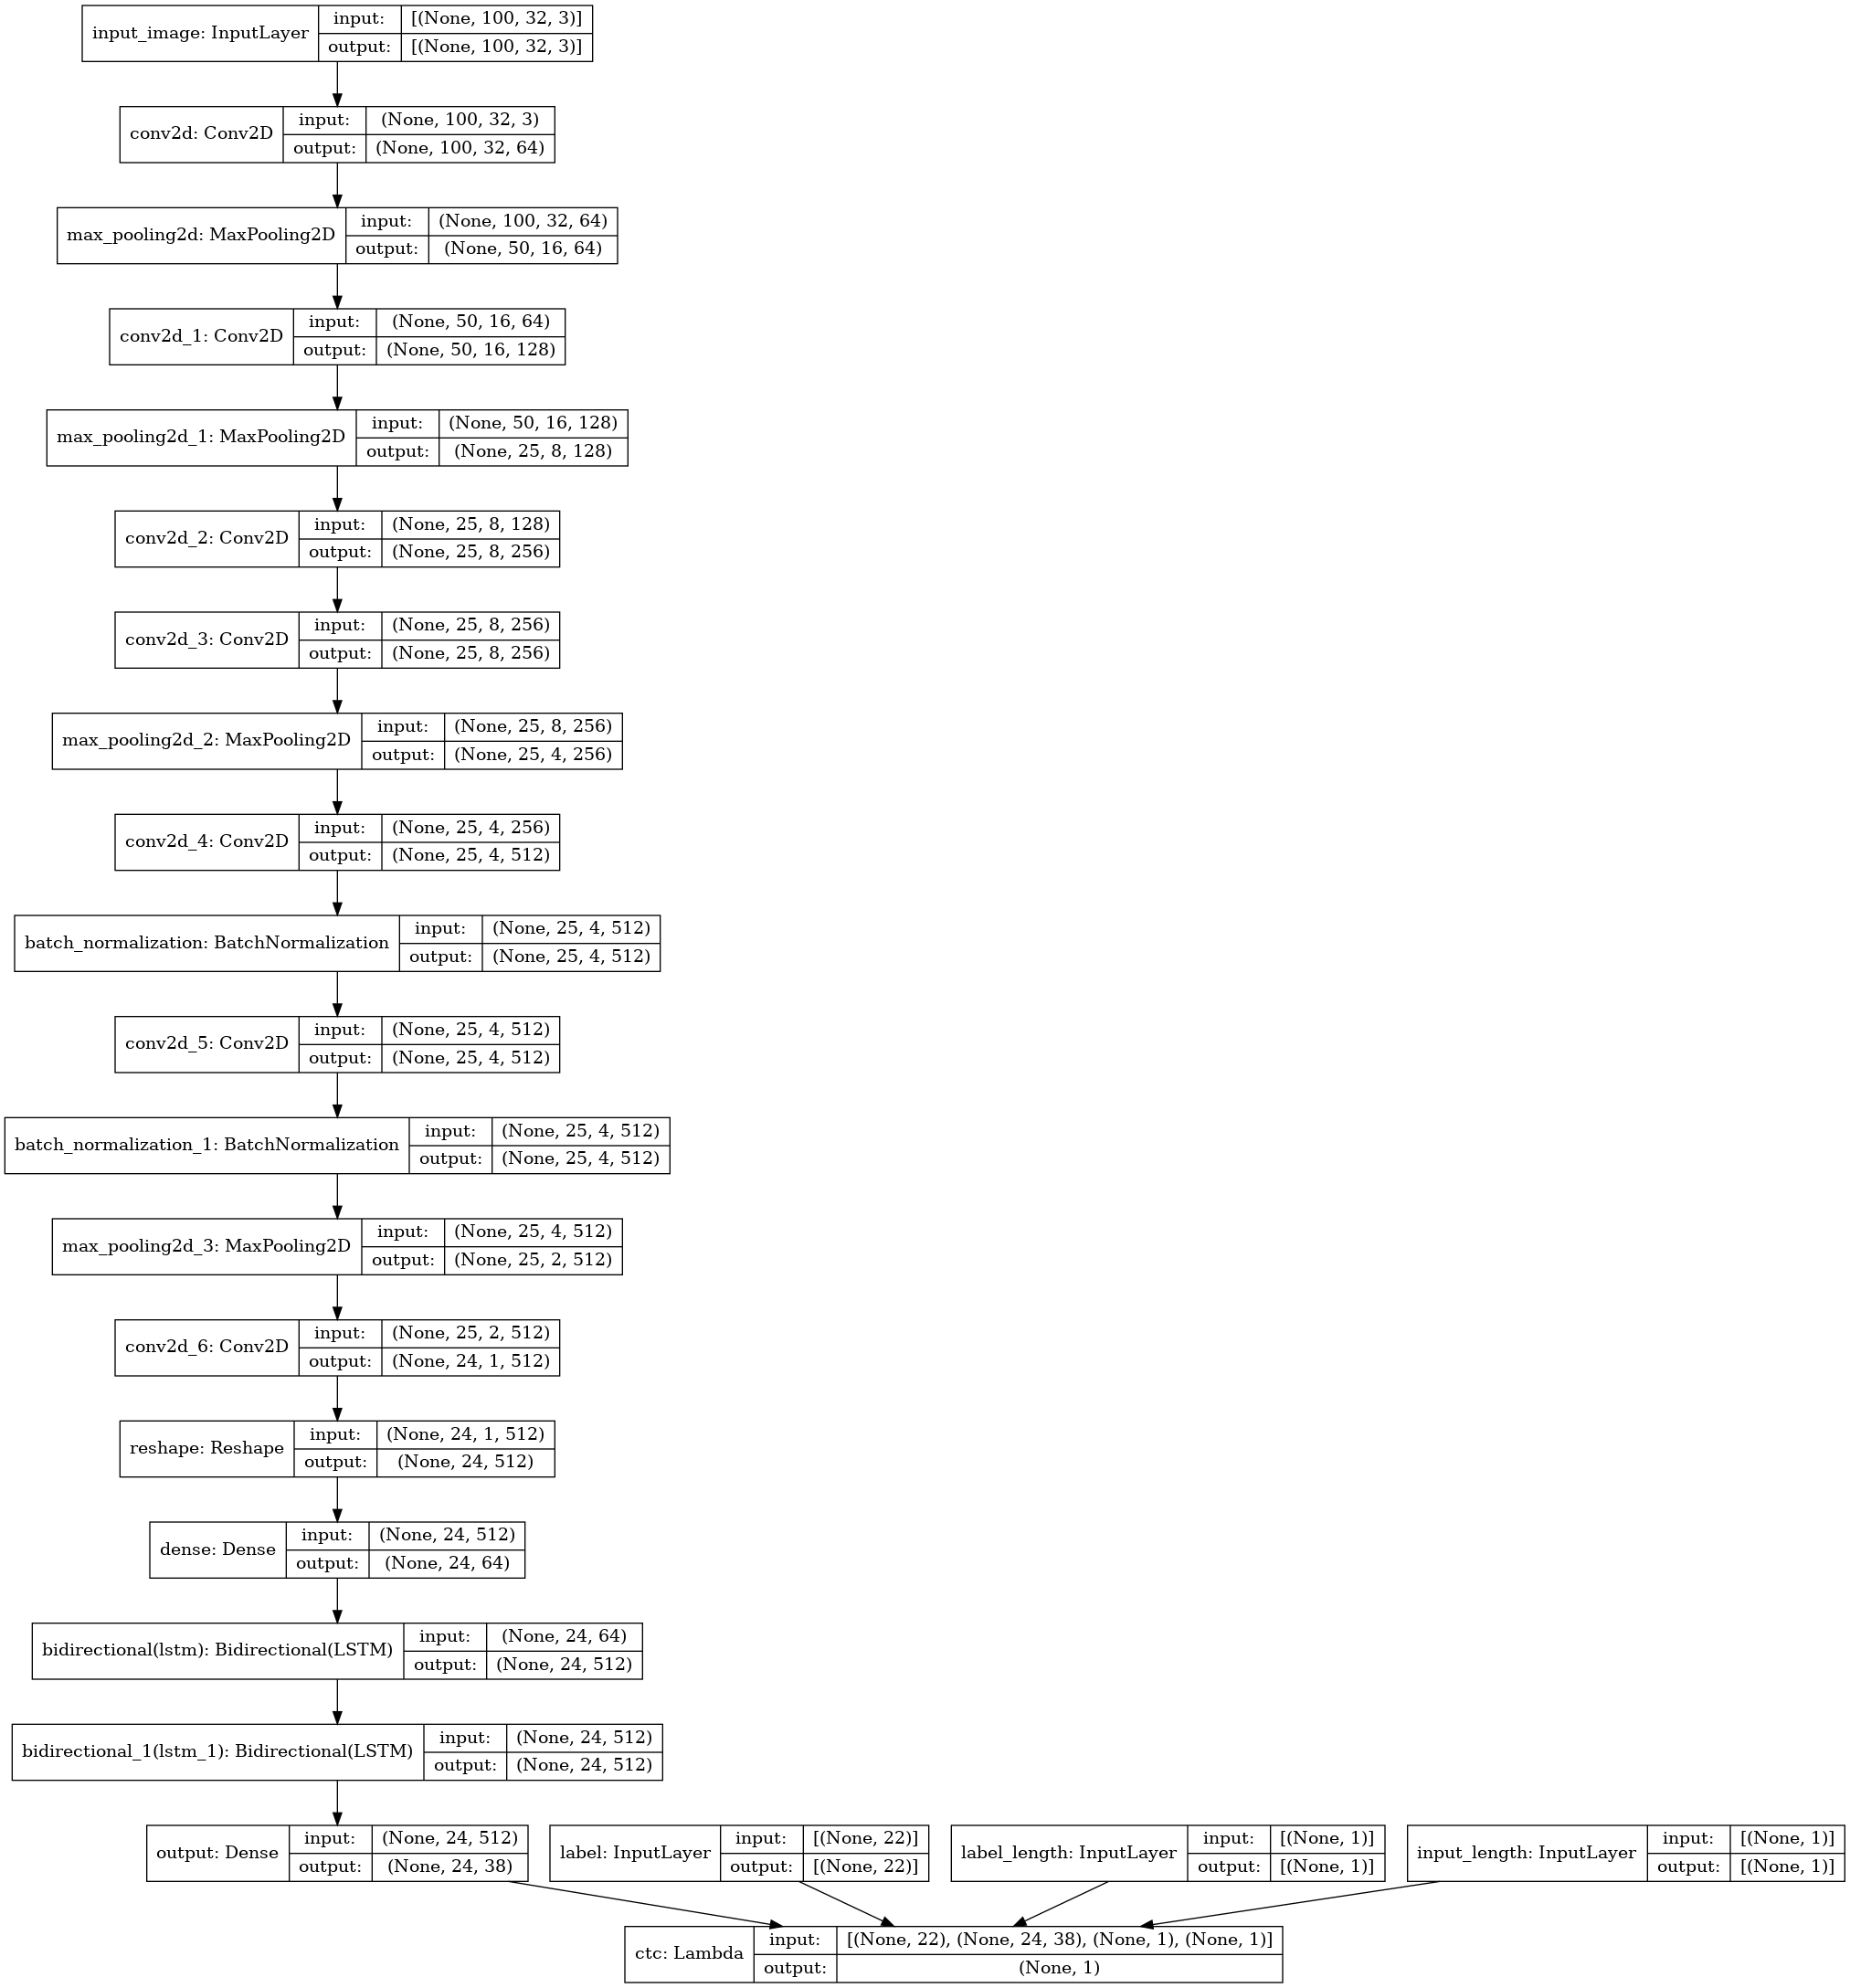

In [13]:
# CRNN Model의 진행과정 출력
tf.keras.utils.plot_model(CRNN, to_file='./CRNN.png', show_shapes=True)

### 2-5. Train & Inference
---
앞에서 정의한 `MJDatasetSequence`로 데이터를 적절히 분리하여 구성된 데이터셋을 통해 학습을 진행해보도록 하겠습니다.

#### ㄱ. 모델 준비
---

In [14]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

#### ㄴ. 모델 학습
---
혹시 모를 상황에 대비하여 `CheckPoint` 와 모델의 빠른 학습을 위한 `EarlyStopping` 적용하여 모델을 학습해보도록 하겠습니다.

- [tf.train.Checkpoint](https://www.tensorflow.org/guide/checkpoint?hl=ko)
- [tf.keras.callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

In [15]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'
)
model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop])

Epoch 1/20
565/565 [==============================] - 202s 304ms/step - loss: 27.5816 - val_loss: 24.7987

Epoch 00001: val_loss improved from inf to 24.79867, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/20
565/565 [==============================] - 157s 278ms/step - loss: 16.5630 - val_loss: 9.2291

Epoch 00002: val_loss improved from 24.79867 to 9.22908, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/20
565/565 [==============================] - 157s 277ms/step - loss: 7.1641 - val_loss: 6.4779

Epoch 00003: val_loss improved from 9.22908 to 6.47793, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/20
565/565 [==============================] - 157s 278ms/step - loss: 5.0120 - val_loss: 5.2385

Epoch 00004: val_loss improved from 6.47793 to 5.23855, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/20
565/565 [==============================] - 157s 277ms/step - loss: 3.9791 - val_loss: 4.7942

Epoch 00005: val_loss 

#### ㄷ. 학습한 모델을 테스트셋을 통해 확인

In [16]:
# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

#### ㄹ. 학습한 모델의 성능 확인

Result: 	 SLINKING9999999999999999


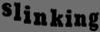

Result: 	 ALEPPO99999999999999999


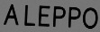

Result: 	 FWENDA999999999999999999


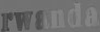

Result: 	 NATHANS99999999999999999


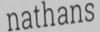

Result: 	 HALLO999999999999999999


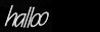

Result: 	 HURLS9999999999999999999


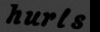

Result: 	 DOWNSIZE9999999999999999


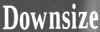

Result: 	 ROBOTIC99999999999999999


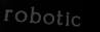

Result: 	 SLOPPY99999999999999999


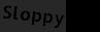

Result: 	 HERMITE99999999999999999


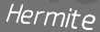

In [17]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

- 다양한 글씨체로 인식을 진행해본 결과, 현재 출력된 이미지 중에서는 3번째와 5번째 이미지를 제외하고는 이미지를 잘 검출하고 인식도 잘 하였음을 확인 할 수 있었습니다.

## 3. End-to-End OCR
---
keras OCR의 Detector class를 이용해서 이미지 내의 문자 위치를 찾아내는 함수를 만들어보도록 하겠습니다.

이를 위해서 keras-ocr을 설치해주고 Detector를 만들어주세요.

### 3-1. 데이터 다운로드
---

In [18]:
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


### 3-2. keras-ocr Detector 함수 구현
---
이미지 경로를 받아 해당 이미지 내의 문자를 찾아내는 함수를 keras-ocr의 Detector를 이용하도록 하겠습니다.

In [21]:
from PIL import Image, ImageDraw

In [22]:
def detect_text(img_path):
    # TODO
    # 배치 크기를 위해서 dimension을 확장해주고 keras-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    # 배치의 첫 번째 결과만 가져옵니다.
    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)    
    img_pil = Image.open(img_path)
    img_draw = ImageDraw.Draw(img_pil)
    ocr_result = detector.detect([img_path])
    ocr_result = np.squeeze(np.array(ocr_result))
    
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return img_pil, cropped_imgs

### 3-3. 이미지 속 단어 Detector 성능 확인
---
위에서 얻은 샘플 데이터속 단어를 detect 후 영역을 표시하는 것으로 성능을 파악해보도록 하겠습니다.

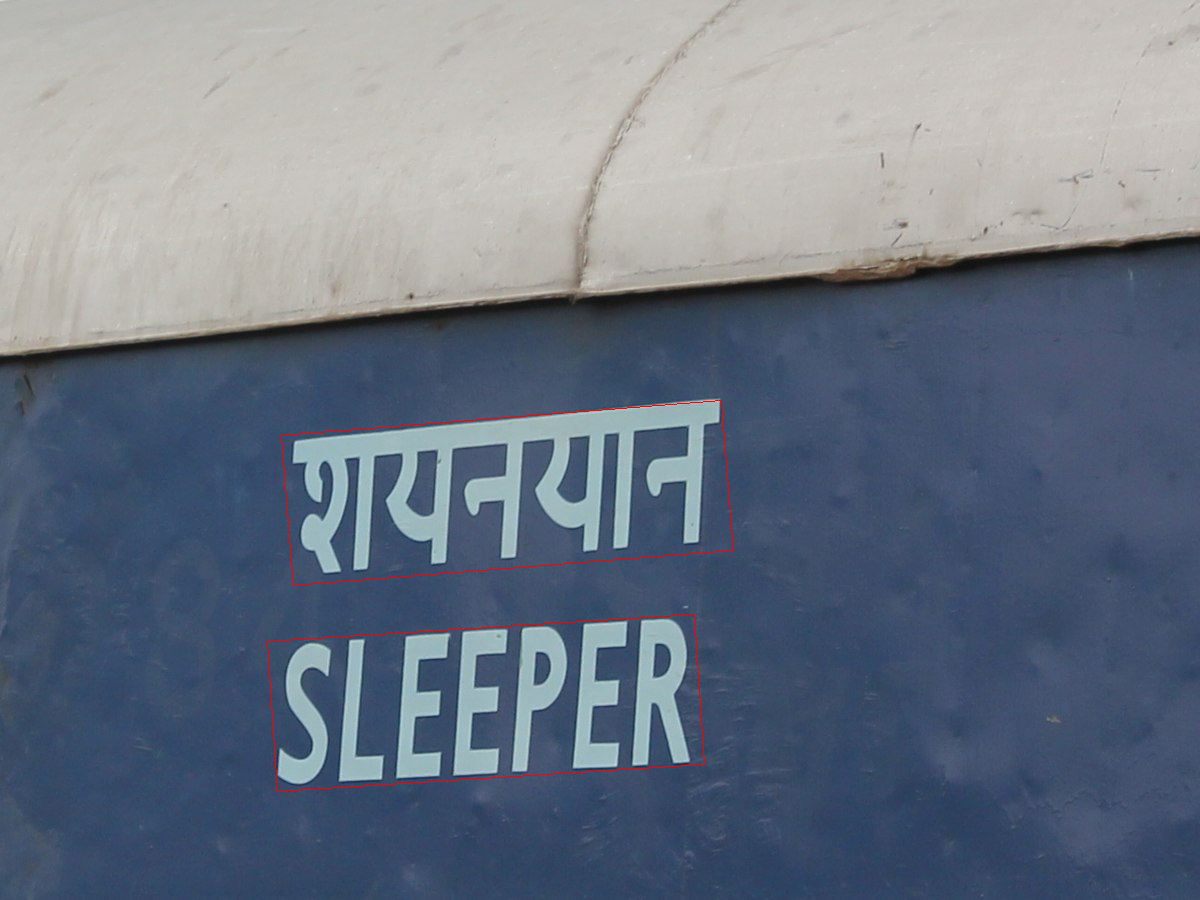

In [23]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

이제 위에서 이미지 내의 단어 이미지를 얻었습니다.

이미지 속 단어를 잘 detect 하였음을 확인 할 수 있습니다.

그러면 Recognition model로 인식하는 함수를 직접 작성하고 그 결과를 출력해보도록 하겠습니다.

### 3-4. Recognition model 함수 구현
---

In [24]:
def recognize_img(pil_img, input_img_size=(100,32)):
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!
    output = model_pred.predict(np.expand_dims(np.array(pil_img.resize((100, 32), 3)).transpose(1, 0, 2), axis=0))
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(np.array(pil_img.resize((100, 32), 3)).astype(np.uint8)))

### 3-5. Keras-ocr 성능 확인
---
이미지 내의 단어를 인식한 영역을 잘라주고, 인식한 단어를 출력해보도록 하겠습니다.

Result: 	 SRARAI99999999999999999


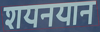

Result: 	 SLEEPER9999999999999999


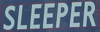

In [25]:
for _img in cropped_img:
    recognize_img(_img)

- 단어가 있는 영역을 잘 인식하였음을 확인 할 수 있었지만, 영어가 아닌 단어는 제대로 검출하지 못하였음을 확인 할 수 있었습니다.

### 3-6. 번외) 추가 이미지로 Keras-ocr 성능 검증
---
Keras-ocr 성능 검증을 위해 다른 이미지를 선정해서 추가적으로 OCR을 진행해보도록 하겠습니다.

In [27]:
SAMPLE_IMG_PATH1 = os.getenv('HOME')+'/aiffel/ocr/sample1.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


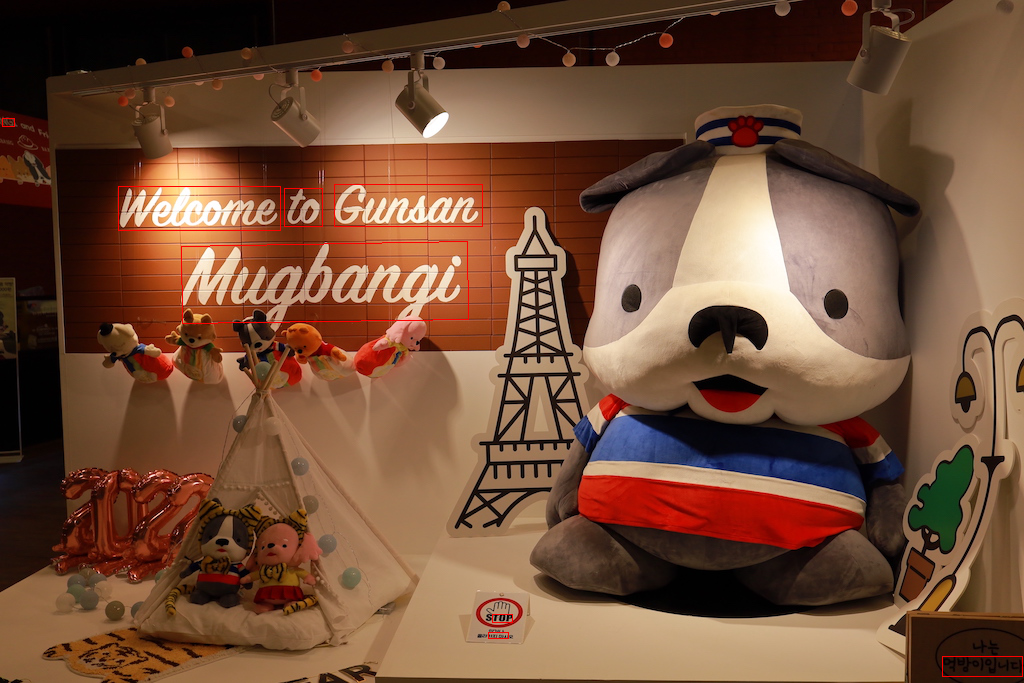

In [28]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH1)
display(img_pil)

Result: 	 ALNESING9999999999999999


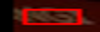

Result: 	 IGUPAUD99999999999999999


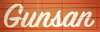

Result: 	 WEREOME99999999999999999


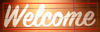

Result: 	 DENLIOEN9999999999999999


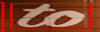

Result: 	 IMUGBANGD999999999999999


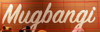

Result: 	 SRUEM9999999999999999999


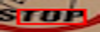

Result: 	 URI999999999999999999999


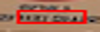

Result: 	 EALED9999999999999999999


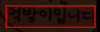

In [29]:
for _img in cropped_img:
    recognize_img(_img)

In [32]:
SAMPLE_IMG_PATH2 = os.getenv('HOME')+'/aiffel/ocr/sample2.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


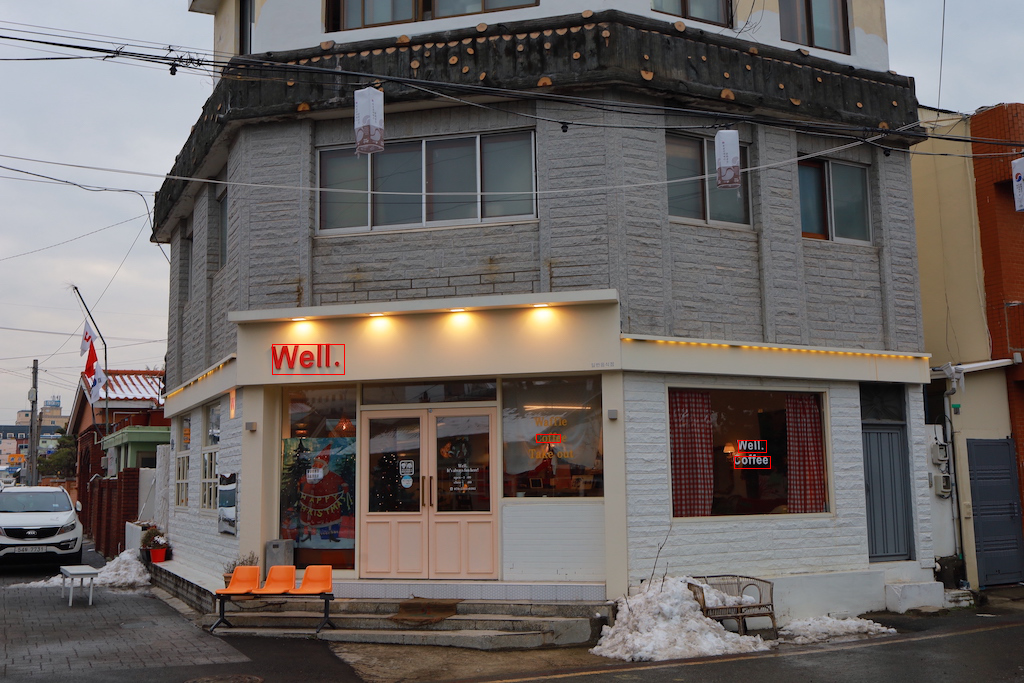

In [33]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH2)
display(img_pil)

Result: 	 UNDETANY9999999999999999


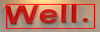

Result: 	 ARTUIEN99999999999999999


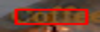

Result: 	 INVELIE99999999999999999


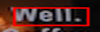

Result: 	 MDOISITER999999999999999


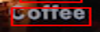

In [34]:
for _img in cropped_img:
    recognize_img(_img)

In [35]:
SAMPLE_IMG_PATH3 = os.getenv('HOME')+'/aiffel/ocr/sample3.jpg'


detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


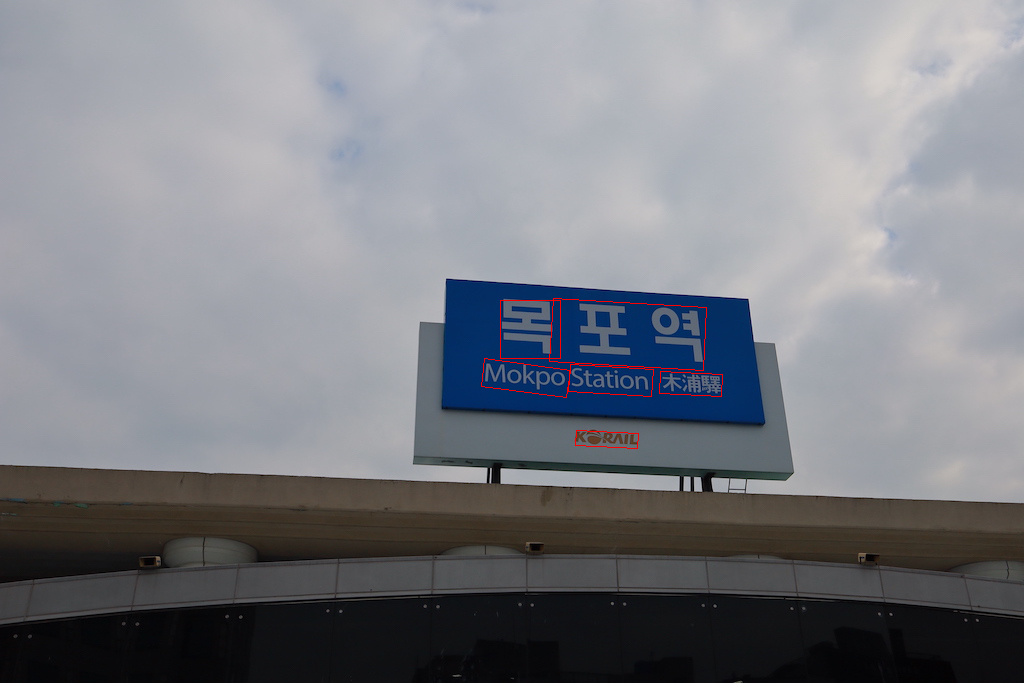

In [36]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH3)
display(img_pil)

Result: 	 S99999999999999999999999


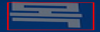

Result: 	 TES999999999999999999999


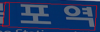

Result: 	 KIEG99999999999999999999


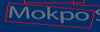

Result: 	 SARENY999999999999999999


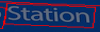

Result: 	 EG9999999999999999999999


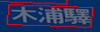

Result: 	 ANENIG999999999999999999


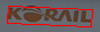

In [37]:
for _img in cropped_img:
    recognize_img(_img)

### Keras-ocr 성능 결론
---
- 본인이 추가로 넣은 샘플 이미지 속에 있는 글자 detect 성능은 좋은 것 같지만, 인식한 이미지 속의 단어가 무엇인지는 잘 검출하지 못 하는 것을 확인할 수 있었습니다. 

## 4. 루브릭 & 회고

### 루브릭
---
1. Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었다.

- 텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치처리 등이 적절히 수행되었다.

2. CRNN 기반의 recognition 모델의 학습이 정상적으로 진행되었다.

- 학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다.

3. keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성되었다.

- 샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다.

### 회고
---

- CRNN recognizer 을 이용해서 원본 이미지 속에 있는 (다양한 폰트와 크기의 text를 포함한) 이미지로 부터 text를 detect 하고 출력하는 성능이 생각보다 좋음을 확인 할 수 있었습니다. (출력된 이미지 기준 정확도 : 10개 중 8개)

- 반면, 비교군으로 제시된 keras-ocr 에서는 이미지 속 text를 detect 하는 능력은 좋았지만, 출력하는 성능은 많이 아쉬웠습니다. (물론 본인이 선정한 이미지 문제 일 수도 있습니다.)

- 이전에 진행했었던 [다양한 OCR모델 비교하기](https://github.com/ghwlsdl/AIFFEL-EXPLORATION/blob/main/Exp%2018/%5BE-18%5D%20%EB%8B%A4%EC%96%91%ED%95%9C%20OCR%EB%AA%A8%EB%8D%B8%20%EB%B9%84%EA%B5%90%ED%95%98%EA%B8%B0.ipynb) 가 많이 생각났었던 이번 프로젝트였다고 생각합니다.

- 그 당시에도 구글 ocr, keras-ocr, Tesseract로 ocr을 진행했었는데, 다른 ocr과 비교 하였을 때 확인했었던 keras-ocr은 이미지 속에서 text를 인식하는 능력은 우월하지만 인식한 텍스트 속의 단어를 출력할 때 아쉬움이 남았던 것과 동일한 아쉬움을 이번 프로젝트를 진행할 때에도 느꼈습니다.

- OCR 분야에도 Attention과 Transformer가 적용함으로써 성능 향상이 되었다고 하던데, 언젠가 새로운 기술이 적용된 OCR를 사용해보고 싶다는 생각이 드는 프로젝트였습니다. keras-ocr은 아쉬움이 남아서..ㅠ

## 5. Reference
---

- [An End-to-End Trainable Neural Network for Image-based Sequence
Recognition and Its Application to Scene Text Recognition](https://arxiv.org/pdf/1507.05717.pdf)
- [tf.keras.backend.ctc_batch_cost
](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/backend/ctc_batch_cost)
- [tf.train.Checkpoint](https://www.tensorflow.org/guide/checkpoint?hl=ko)
- [tf.keras.callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
- [Transformer를 적용한 ocr 논문 리뷰](https://hulk89.github.io/machine%20learning/2019/05/15/A-Simple-and-Robust-Convolutional-Attention-Network-For-Irregular-Text-Recognition/)